<a href="https://colab.research.google.com/github/mollyshillabeer/twitter_nlp/blob/main/tweet_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README

This notebook is for the final project for CISC 451. It looks at our analysis of Covid-19 related tweets produced in 2021.

> **Hint:** This code is best accompanied by our [report](https://docs.google.com/document/d/1-nZ92qb8xWYWmqjf8uOR_EM756Etr_WP1u_KgCDWYrA/edit?usp=sharing) and [presentation](https://queensuca-my.sharepoint.com/:p:/r/personal/17mes10_queensu_ca/Documents/451_final.pptx?d=w5132e5a4a01742038b05b82ae08096e7&csf=1&web=1&e=uOMqKf).

All code in this document has been authored by Derek Xu, Ekim Karabey, and Molly Shillabeer.


### Getting Started

To get started, please create a folder called `CISC451` in your Google Drive. Within your folder place `vaccination_all_tweets.csv`, `vaccination_all_tweets_final.csv` and `sentiments.csv`.

If running this locally, you also instead to change the `root` variable in cell 1:

```
...
drive.mount('/content/gdrive')
root = 'some/path/here/{}' <---

path = root.format('vaccination_all_tweets.csv')
...
```

If running on colab, you should also change your runtime to a GPU or TPU, since some operations can take long times on a cpu.


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root = '/content/gdrive/My Drive/CISC451/data/{}'

path = root.format('vaccination_all_tweets.csv')
path2 = root.format('vaccination_all_tweets_final.csv')
sentiment_path = root.format('sentiments.csv')

Mounted at /content/gdrive


In [ ]:
!pip install transformers --quiet
!pip install fasttext --quiet

!python --version

     |████████████████████████████████| 5.5 MB 23.7 MB/s 
     |████████████████████████████████| 182 kB 63.7 MB/s 
     |████████████████████████████████| 7.6 MB 55.5 MB/s 
     |████████████████████████████████| 68 kB 7.0 MB/s 
Python 3.7.15


In [ ]:
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import groupby
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from nltk.corpus import stopwords
import nltk
import html

# Pretrained models imports
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TFAutoModelForSequenceClassification
from scipy.special import softmax
import csv
import urllib.request
import torch

# Data Preprocessing

Firstly, we can remove any entry where the field `is_retweet` is `True`, since any retweet would be a duplicate text entry. (Actually, there don't seem to be any retweets in the dataset, but if there were, we'd remove them.) Subsequently, we can also drop the `is_retweet` column entirely since every entry will be `False` and thus the column contributes no information.

We can also remove the `id` column since we already have a unique identifier in the form of the dataframe's row index, and the `id` doesn't contribute any other information.

In [ ]:
pd.set_option('display.max_colwidth', None)

df = pd.read_csv(path)
df2 = pd.read_csv(path2)
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228202,1460170772299665408,VaxBLR,"Bengaluru, India","Hourly updates on FREE and PAID 18+ and 45+ vaccine slot availability across #Bengaluru BBMP,URBAN & RURAL",2021-06-21 08:44:34,31,0,0,False,2021-11-15 09:00:15,45+ #URBAN #Bengaluru #CovidVaccine Availability for 15/11 at 02:30PM\nFREE Slots 0\nPAID Slots \n#COVISHIELD - Dose1:… https://t.co/F0WeHxW7oe,"['URBAN', 'Bengaluru', 'CovidVaccine', 'COVISHIELD']",VaxBlr,0,0,False
228203,1460163268262051841,VaxBLR,"Bengaluru, India","Hourly updates on FREE and PAID 18+ and 45+ vaccine slot availability across #Bengaluru BBMP,URBAN & RURAL",2021-06-21 08:44:34,31,0,0,False,2021-11-15 08:30:26,"18-44 #BBMP #Bengaluru #CovidVaccine Availability for 15/11 at 02:00PM\nFREE Slots \n#COVISHIELD - Dose1:1676, Dose2:… https://t.co/3k8SHHcVVd","['BBMP', 'Bengaluru', 'CovidVaccine', 'COVISHIELD']",VaxBlr,0,1,False
228204,1460163224221851655,VaxBLR,"Bengaluru, India","Hourly updates on FREE and PAID 18+ and 45+ vaccine slot availability across #Bengaluru BBMP,URBAN & RURAL",2021-06-21 08:44:34,31,0,0,False,2021-11-15 08:30:15,18-44 #URBAN #Bengaluru #CovidVaccine Availability for 15/11 at 02:00PM\nFREE Slots 0\nPAID Slots \n#COVISHIELD - Dose… https://t.co/INCb38UKmA,"['URBAN', 'Bengaluru', 'CovidVaccine', 'COVISHIELD']",VaxBlr,0,0,False
228205,1460156376995573765,Gatti Valentino🐾,Southern Africa,"Entrepreneur, self taught cook🍲🌮 @Chelsea @Ferrari, @hornets political activist, London is Blue 💙, Property developer, Aries♈",2019-08-28 10:31:43,8103,3113,45726,False,2021-11-15 08:03:03,They promote their Vaccines leaving out the stronger @Russia vaccine \n#SputnikV https://t.co/nD1J8NvqfA,['SputnikV'],Twitter for Android,

In [ ]:
# Check for missing values
df.isnull().sum()

id                      0
user_name               2
user_location       66911
user_description    17018
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            49703
source                119
retweets                0
favorites               0
is_retweet              0
dtype: int64

In [ ]:
df.query('is_retweet == False', inplace=True)
df.drop('is_retweet', axis=1, inplace=True)

# Separating dates from times
df['date_clean']=pd.to_datetime(df['date']).dt.date
df['time']=pd.to_datetime(df['date']).dt.time
df['user_created_date']=pd.to_datetime(df['user_created']).dt.to_period('M')

In [ ]:
# Seperating hashtags and tags out of the text into their own columns

def extract_tags(s):
    return list(set(part[1:] for part in s.split() if part.startswith('@')))

def extract_hashtags(s):
    return list(set(part[1:] for part in s.split() if part.startswith('#')))


df['tags'] = df.apply(lambda row: extract_tags(row.text), axis=1)
df['hashtags'] = df.apply(lambda row: extract_hashtags(row.text), axis=1)
#add full tweets, remove ones with no full text
df3=df2[['id', 'text']]
df=pd.merge(df, df3, on='id')
df.drop('id', axis=1, inplace=True)

# Data Exploration and Visualization

This section is mostly straightforward. It doesn't contain any data transformations or feature engineering -- instead it contains a bunch of tables and graphs for better understanding our data.

In [ ]:
# Check data distribution

df.describe().applymap(lambda x: f'{x:0.2f}')

,user_followers,user_friends,user_favourites,retweets,favorites
count,199266.00,199266.00,199266.00,199266.00,199266.00
mean,109517.40,991.75,11998.47,2.54,11.12
std,895816.17,5560.53,39718.01,53.05,202.87
min,0.00,0.00,0.00,0.00,0.00
25%,57.00,17.00,57.00,0.00,0.00
50%,342.00,222.00,810.00,0.00,0.00
75%,1749.00,786.00,6861.00,0.00,2.00
max,16353048.00,582461.00,1299600.00,12294.00,54017.00


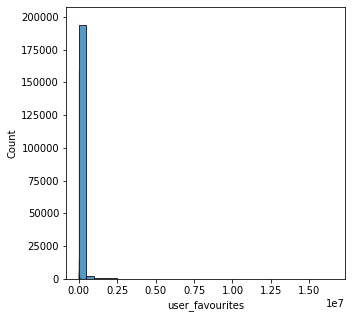

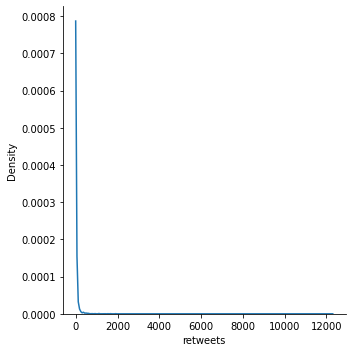

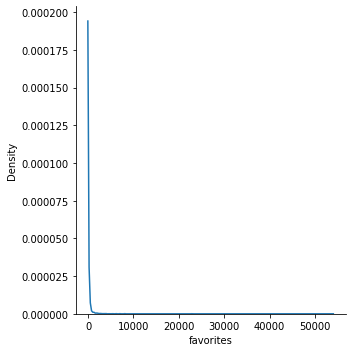

In [ ]:
# Data visualization

df1=df.drop(df[df.favorites>20000].index)
df1=df1.drop(df1[df1.favorites<200].index)
plt.figure(figsize=(5,5))
sns.histplot(df, x='user_favourites',binwidth=10000)
sns.histplot(df, x='user_followers',binwidth=500000)
sns.histplot(df, x='user_friends',binwidth=10000)
sns.displot(df, x='retweets',kind='kde')
sns.displot(df, x='favorites',kind='kde')

[[]]

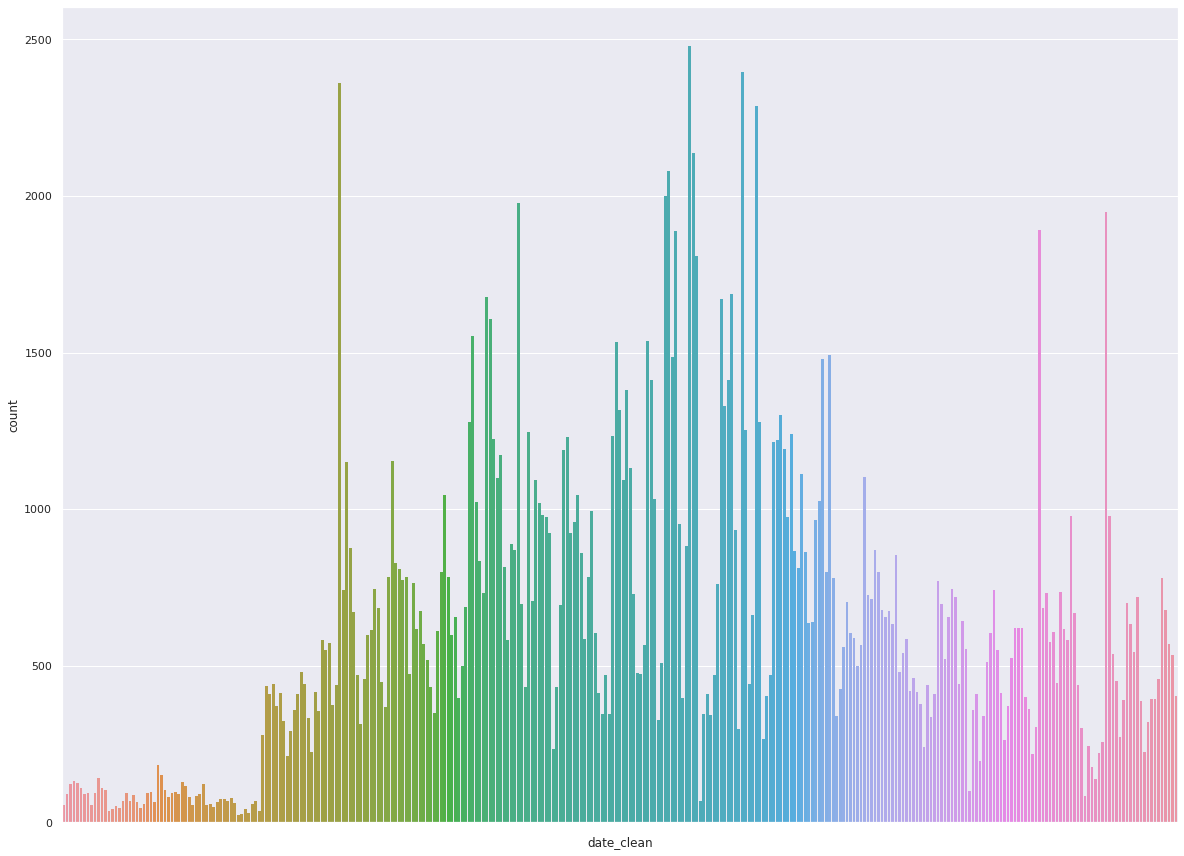

In [ ]:
#number of tweets per day
plt.figure(figsize=(20,15))
sns.set(font_scale=1)
g=sns.countplot(x=df['date_clean'].sort_values(),linewidth = 0)
g.set(xticklabels=[])

[[]]

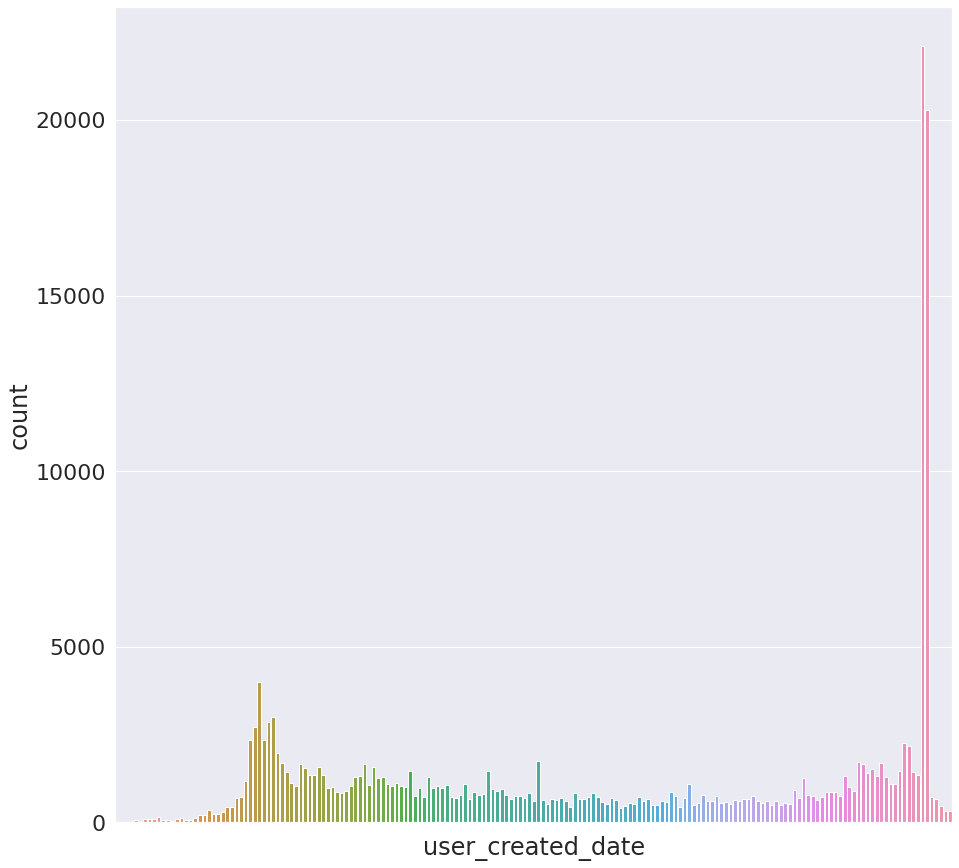

In [ ]:
plt.figure(figsize=(15,15))
sns.set(font_scale=2)
g=sns.countplot(x=df['user_created_date'].sort_values())
g.set(xticklabels=[])


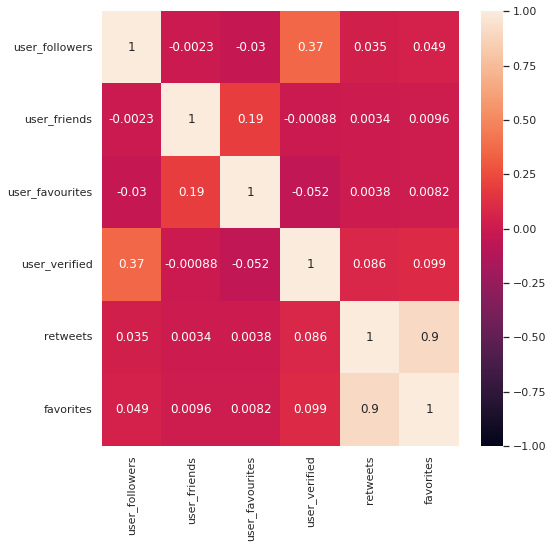

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),vmin=-1,vmax=1, annot=True)

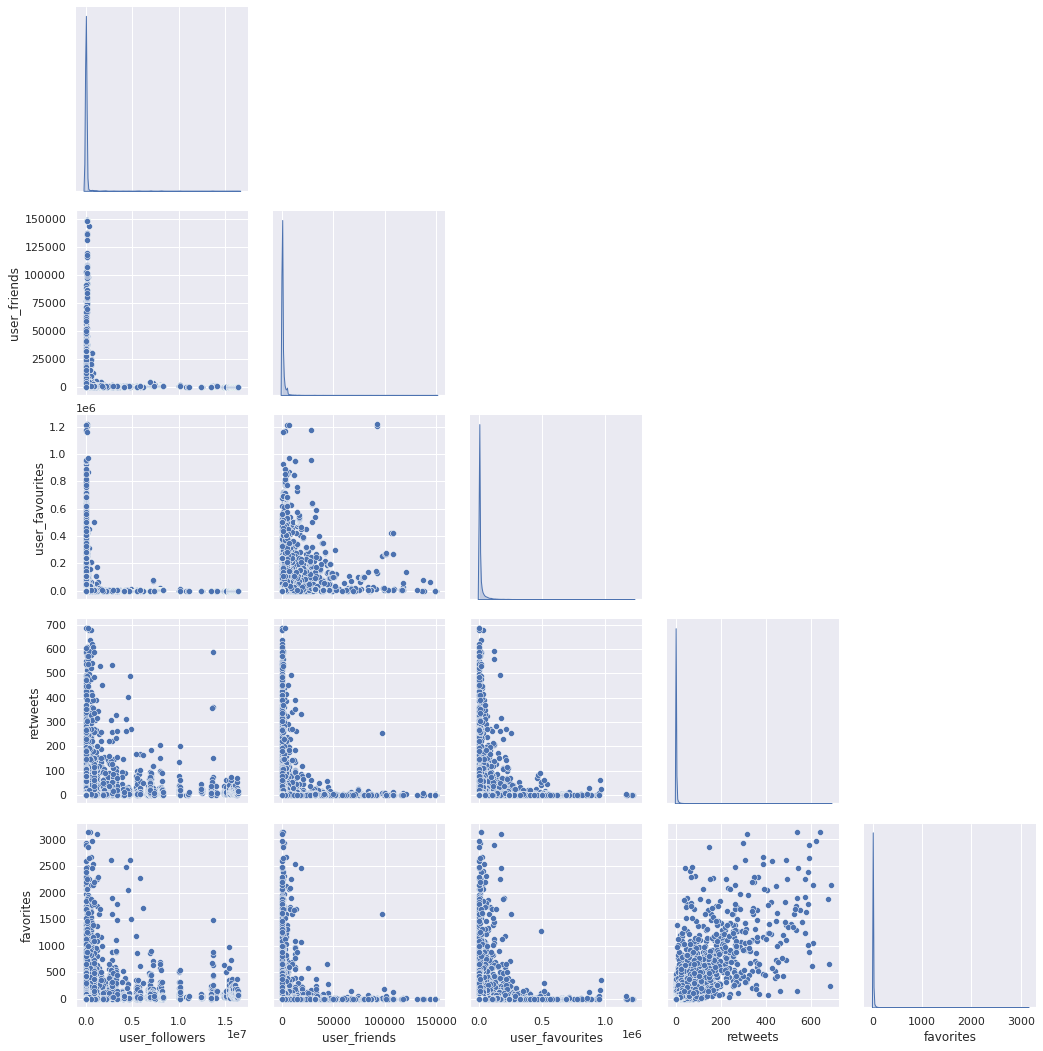

In [ ]:
#remove extreme outliers for readability of graph. these are not removed from dataset used for training
sns.set(font_scale=1)
cols = ['user_friends','user_favourites','retweets','favorites']
Q1 = df[cols].quantile(0.01)
Q3 = df[cols].quantile(0.999)
IQR = Q3 - Q1
df_outliers = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
g=sns.pairplot(df_outliers,diag_kind='kde',corner=True,
             x_vars=['user_followers','user_friends','user_favourites','retweets','favorites'],
             y_vars=['user_followers','user_friends','user_favourites','retweets','favorites'])
g.fig.set_size_inches(15,15)

In [ ]:
# Common words visualizations
# Filtering to include only alphanumeric characters and '; case insensitive.

def get_wordlist(df_param):
    # TODO: Improve filtering to include non-alphanumerical characters
    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '\'']
    wordlist = ' '.join(df_param['text_y']).lower().split()
    wordlist = [ele for ele in wordlist if all(ch in alphabet for ch in ele)]
    stop_words = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
    wordlist_filtered = [ele for ele in wordlist if ele not in stop_words]
    return wordlist_filtered

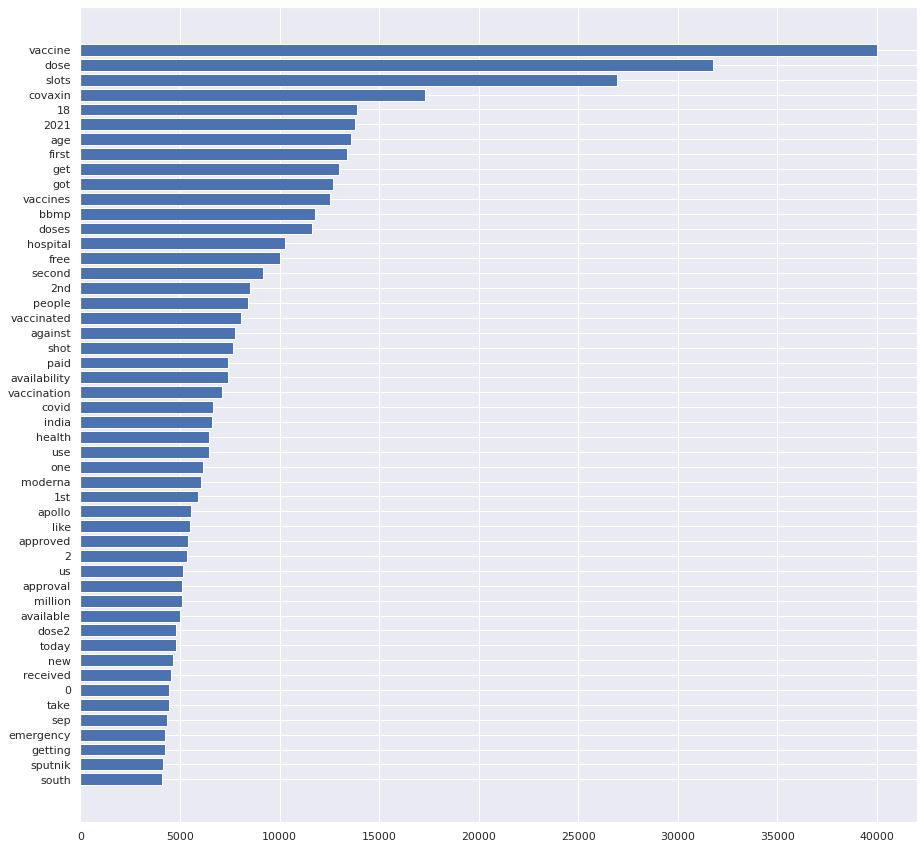

In [ ]:
# Building the bar graph
wordlist = get_wordlist(df)
words, counts = zip(*Counter(wordlist).most_common(50))

plt.rcParams['figure.figsize'] = (15,15)
sns.set(font_scale=1)
plt.barh(words[::-1], counts[::-1])
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (15,15)
print(len(wordlist))
words, counts = zip(*Counter(wordlist).most_common()[:-50-1:-1])
print(words)

1902461
('dictatorial', 'rigth', 'unsupported', 'aprueben', 'sanatear', 'norma', 'televisa', 'rdc', 'irritant', 'efective', "chemists'", "spike'", 'mendatory', "'mismatch'", 'trawel', 'appove', '3er', 'reassess', 'tage', '700000', 'rfks', 'antivaxxine', "hanuman's", "don'tcha", 'irreparable', "processes'", "'time", 'abolishes', 'oeople', 'kens', '8502', '8471', 'ofi9', 'cowtowing', 'indeginious', 'couptaji', 'chynese', 'cag', 'sura', 'grupo', 'equivalence', 'magnifying', 'stonewall', 'torrid', 'forchildren', 'whammies', 'blurring', 'lov', 'technologist', 'inv')


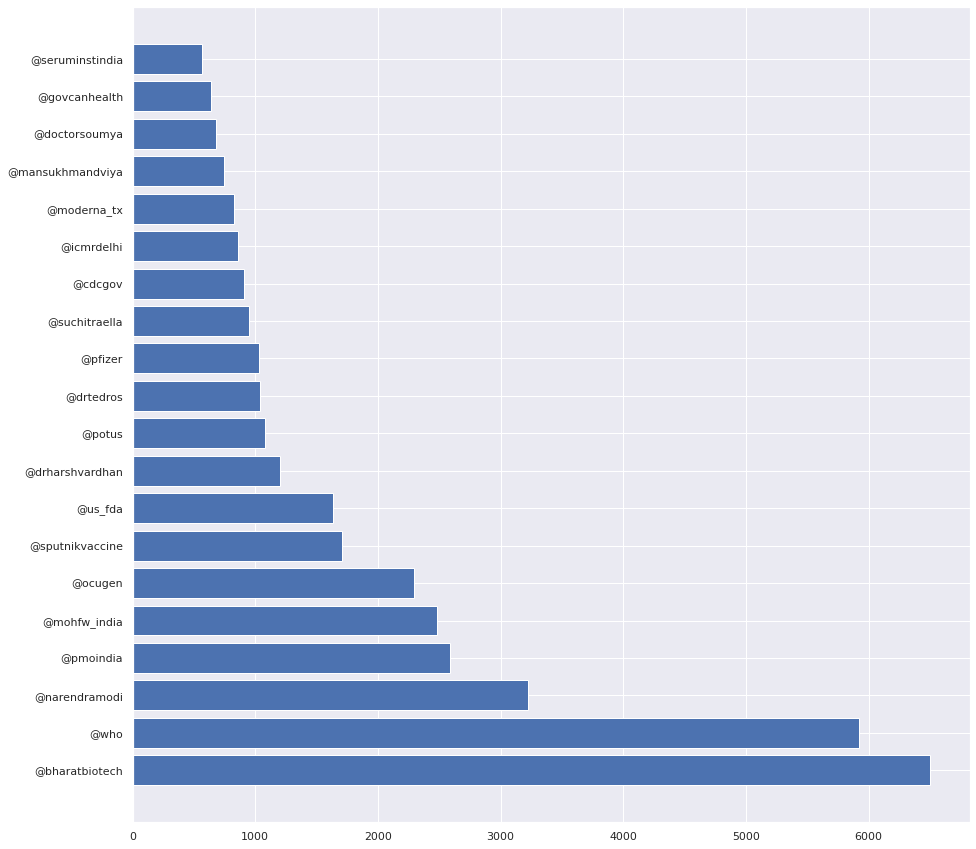

In [ ]:
def tag_filter(counter_tuple):
    word, count = counter_tuple
    if not '@' in word:
        return False
    if len(word) < 4:
        return False
    if count < 100:
        return False
    return True

wordlist = ' '.join(df['text_y']).lower().split()
tagged_posts = list(filter(tag_filter, Counter(wordlist).items()))
tagged_posts.sort(key=lambda tup: tup[1], reverse=True)

tags, counts = zip(*tagged_posts[:20])

plt.rcParams['figure.figsize'] = (15,15)
plt.barh(tags, counts)
plt.show()
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Pretrained Model and Sentiment Analysis

This section focuses on our attempt to use the pretrained Twitter roBERTa model to generate labels for our data. If `sentiments.csv` is defined then it is imported. Otherwise, the roBERTa model is set up and predicts labels for our text data.

As mentioned in the report and presentation, this part goes unused due to label imbalance.

In [ ]:
   def cleaning(text):
    new_text = []

    for t in text.split(' '):
        t=html.unescape(t)
        t=t.lower()
        t=t.replace('\n',' ')
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = '' if '#' in t else t
        #t = '' if t.isnumeric() else t
        new_text.append(t)

    return ' '.join(new_text)

In [ ]:
task = 'sentiment'
MODEL = f'cardiffnlp/twitter-roberta-base-{task}'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Download label mapping
labels = []
mapping_link = f'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt'
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split('\n')
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def calculate_sentiment():
    # Encoding step
    text = df['text_y']
    text = text.apply(lambda row: cleaning(row))
    encoded_input = text.apply(lambda row: tokenizer(row, return_tensors='pt'))

    # Decoding step
    scores = []
    for i, row in encoded_input.items():
        output = model(**row)
        score = output[0][0].detach().numpy()
        score = softmax(score)
        scores.append(np.argmax(score))
        if i % 1000 == 0:
            print(i)
        i+=1

    # Save output to CSV
    score_df = pd.DataFrame({'sentiment':scores})
    score_df.to_csv('/content/gdrive/My Drive/CISC451/sentiments.csv')

In [ ]:
# Try to import pre-calculated sentiment, if not there calculate it

sentiment_exists = os.path.exists(sentiment_path)
if not sentiment_exists:
    calculate_sentiment()

score_df = pd.read_csv(sentiment_path)
score_df.describe()

,Unnamed: 0,sentiment
count,199266.000000,199266.000000
mean,99632.500000,1.002369
std,57523.283708,0.062520
min,0.000000,0.000000
25%,49816.250000,1.000000
50%,99632.500000,1.000000
75%,149448.750000,1.000000
max,199265.000000,2.000000


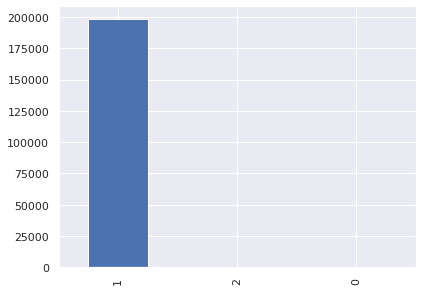

In [ ]:
# Show bar graph of the three sentiments
fig,ax = plt.subplots()
score_df = pd.DataFrame({'sentiment':score_df['sentiment']})
score_df['sentiment'].value_counts().plot(ax=ax, kind='bar')

In [ ]:
score_df['sentiment'].value_counts()

1    198486
2       626
0       154
Name: sentiment, dtype: int64

# Modeling

First, we do some final data processing. This starts off by removing duplicate tweets, removing stopwords, lemmatizing words and encoding punctuation.

> **Note**: We chose to leave this step in the *Modeling* section instead of the *Data Preprocessing* section because it had to be done after our project pivoted away from the pre-trained model.

Afterwards, the text is vectorized into tf_idf, and fed into a k-means clustering model.

In [ ]:
import html
def lemmatize_text(text):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

def data_prep(df):
    #drop duplicates
    nltk.download("stopwords")
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    df = df.drop_duplicates(subset='text_y',keep='first')

    #clean
    df['text_y'] = df['text_y'].apply(lambda row: cleaning(row))

    #remove stopwords
    stop=stopwords.words("english")
    stop.extend(['covid','vaccination','vaccine','dose','covid-19'])
    stop.remove('not')
    df['text_y']=df['text_y'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    #lemmatization
    df['text_y']=df['text_y'].apply(lemmatize_text)
    df['text_y']=[' '.join(map(str, l)) for l in df['text_y']]

    #remove emojis
    filter_char = lambda c: ord(c) < 256
    df['text_y']=df['text_y'].apply(lambda row: cleaning(row))
    df['text_y']=df['text_y'].apply(lambda s: ''.join(filter(filter_char, s)))

    #encode punctuation
    df['text_y']=df['text_y'].apply(lambda row: row.replace('?',' hasQuestion'))
    df['text_y']=df['text_y'].apply(lambda row: row.replace('!',' hasExclamation'))

    # wordlist = ' '.join(df['text_y']).split()
    # words, counts = zip(*Counter(wordlist).most_common(100))
    # df['text_y']=df['text_y'].apply(lambda x: ' '.join([word for word in x.split() if word not in (words)]))

    return df

In [ ]:
df = data_prep(df)

In [ ]:
count=df['text_y'].str.split().str.len()
df['count']=count
df=df[df['count']>1]

In [ ]:
# This tends to lead to overfitting if too high
VOCAB_SIZE = 700

#tf_idf, n_grams
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    ngrams=4,
    output_mode='tf_idf',
    standardize='lower_and_strip_punctuation'
)

encoder.adapt(df['text_y'].values)
vocab = np.array(encoder.get_vocabulary())

In [ ]:
train_x = encoder(df.iloc[:]['text_y'])

In [ ]:
CLUSTER_NUM=[3]
total_samples=df.shape[0]
for cluster in CLUSTER_NUM:
  model = KMeans(n_clusters=cluster,n_init=75,max_iter=1000, random_state=0)
  #model = AgglomerativeClustering(n_clusters=cluster)
  #model = SpectralClustering(n_clusters=cluster, assign_labels='kmeans', random_state=0, gamma=0.01, n_init=20)
  #model=DBSCAN(eps=5, min_samples=10)
  clusters=model.fit_predict(train_x)
  labels = model.labels_
  label_indexes = []

  for num in range(cluster):
      # get cluster for each sample
      indexes = [idx for idx, label in enumerate(labels) if label == num]
      label_indexes.append(indexes)

  print("Silhouette Score (-1 to 1, 1 being best): {0:.4f}".format(silhouette_score(train_x, labels,sample_size=10000)))
  print("Davies Bouldin Score (0 being best): {0:.4f}".format(davies_bouldin_score(train_x, labels)))
  print("Calinski-Harabasz Score: {0:.4f}".format(calinski_harabasz_score(train_x, labels)))
  for i in range(cluster):
    n_samples=df.iloc[label_indexes[i]].shape[0]
    print("cluster "+str(i)+": "+str(n_samples) + " " +str(round(n_samples/total_samples*100,2))+"%")

Silhouette Score (-1 to 1, 1 being best): 0.5094
Davies Bouldin Score (0 being best): 0.6039
Calinski-Harabasz Score: 472558.8224
cluster 0: 42432 22.13%
cluster 1: 74138 38.67%
cluster 2: 75138 39.19%


# Results & Analysis

In this section we take a look at the characteristics of our clusters. First we look at commonly occuring words, and then we look at the tweet properties surrounding each cluster.

In [ ]:
cluster_df = df.iloc[label_indexes[0]]
print("Cluster percent: {0:.4}".format(cluster_df.size / df.size))

wordlist = get_wordlist(cluster_df)
words, counts = zip(*Counter(wordlist).most_common(10))
print("Most Common Words: \n {} \n".format(words))

cluster_df['text_y']

Cluster percent: 0.2213
Most Common Words: 
 ('hasexclamation', 'hasquestion', 'vaccine', 'get', 'dos', 'first', 'people', 'got', '2nd', 'shot') 



1                                 fact immutable, senator, even not ethically sturdy enough acknowledge them. (1) born canada. (2) developed germany.(3) scientist behind it, muslim turkish immigrant germany &
4                                                                         bit sad claim fame success patriotic competition usa, canada, uk eu. together, win together. company proud modern science & technology
8                                  death closing 300,000 mark... million people wait  hasExclamation - first u shipment arrive 145 location around country monday morning, general gu perna said press briefing.
27                                                                           respect due process not give approval instead 29th december. surely multiple country approving already proof enough hasQuestion via
33                                                                                          one side effect carry bigger risk (about 10,000 time risk way lol) disea

In [ ]:
cluster_df = df.iloc[label_indexes[1]]
print("Cluster percent: {0:.4}".format(cluster_df.size / df.size))

wordlist = get_wordlist(cluster_df)
words, counts = zip(*Counter(wordlist).most_common(10))
print("Most Common Words: \n {} \n".format(words))

cluster_df['text_y']

Cluster percent: 0.3867
Most Common Words: 
 ('hasexclamation', 'age', 'hasquestion', 'got', 'first', 'get', 'shot', 'slot', 'vaccinated', 'second') 



2                                                                        explain need
3         anyone useful advice/guidance whether safe whilst breastfeeding hasQuestion
6                                                     vaccine; getting it hasQuestion
7                                                    state start getting monday, say 
9                           best wish u much success & defeating virus hasExclamation
                                             ...                                     
199243                                  travel chaos: delay entry traveler inoculated
199245                                 however, first available, ill remain home pay.
199252                                                    explore locality like never
199254                                         delay entry tourist vaccinated russias
199264                                               promote vaccine leaving stronger
Name: text_y, Length: 74138, dtype: object

In [ ]:
cluster_df = df.iloc[label_indexes[2]]
print("Cluster percent: {0:.4}".format(cluster_df.size / df.size))

wordlist = get_wordlist(cluster_df)
words, counts = zip(*Counter(wordlist).most_common(10))
print("Most Common Words: \n {} \n".format(words))

cluster_df['text_y']

Cluster percent: 0.3919
Most Common Words: 
 ('slot', 'covaxin', '18', '2021', 'hasexclamation', 'free', 'hasquestion', 'hospital', '1410', 'paid') 



0                                                         world wrong side history year, hopefully, biggest effort we've ever known put u back right one
5                                                             not many bright day 2020 best 1. winning 2. getting recommending looking ahead - 12/15 get
10                                               agency also released new information health care provider patient u shipped million dos across country.
11                                                           woman healthcare provider asking safety pregnant breastfeeding woman recommendation morning
12                                "expect 145 site across state receive monday, another 425 site tuesday," said official charge distribution. read more:
                                                                               ...                                                                      
199260                            18-44 availability 15/11 03:00pm free slot - dos

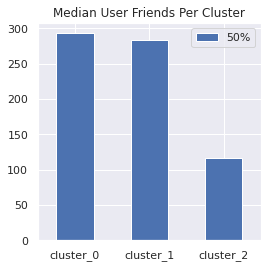

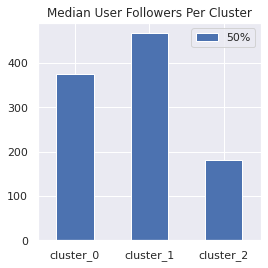

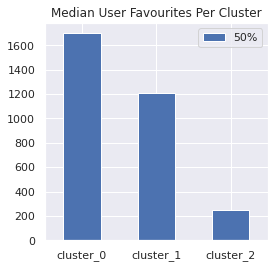

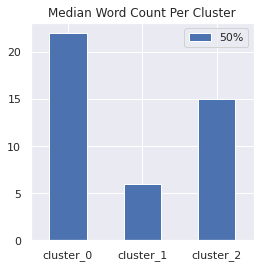

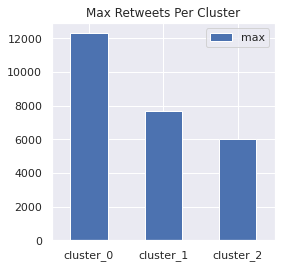

In [ ]:
temp_list = [df.iloc[label_index].describe()['user_friends'][['50%']] for label_index in label_indexes]
temp_df = pd.DataFrame(temp_list, index =['cluster_0', 'cluster_1', 'cluster_2'])
temp_df.plot.bar(rot=0, figsize=(4,4), title="Median User Friends Per Cluster")

temp_list = [df.iloc[label_index].describe()['user_followers'][['50%']] for label_index in label_indexes]
temp_df = pd.DataFrame(temp_list, index =['cluster_0', 'cluster_1', 'cluster_2'])
temp_df.plot.bar(rot=0, figsize=(4,4), title="Median User Followers Per Cluster")

temp_list = [df.iloc[label_index].describe()['user_favourites'][['50%']] for label_index in label_indexes]
temp_df = pd.DataFrame(temp_list, index =['cluster_0', 'cluster_1', 'cluster_2'])
temp_df.plot.bar(rot=0, figsize=(4,4), title="Median User Favourites Per Cluster")

temp_list = [df.iloc[label_index].describe()['count'][['50%']] for label_index in label_indexes]
temp_df = pd.DataFrame(temp_list, index =['cluster_0', 'cluster_1', 'cluster_2'])
temp_df.plot.bar(rot=0, figsize=(4,4), title="Median Word Count Per Cluster")

temp_list = [df.iloc[label_index].describe()['retweets'][['max']] for label_index in label_indexes]
temp_df = pd.DataFrame(temp_list, index =['cluster_0', 'cluster_1', 'cluster_2'])
temp_df.plot.bar(rot=0, figsize=(4,4), title="Max Retweets Per Cluster")

In [ ]:
df.iloc[label_indexes[0]].describe()

,user_followers,user_friends,user_favourites,retweets,favorites,count
count,4.243200e+04,42432.000000,4.243200e+04,42432.000000,42432.000000,42432.000000
mean,1.267250e+05,1052.829138,1.423886e+04,4.944712,18.868990,22.535398
std,9.907178e+05,4977.351244,4.162449e+04,89.906158,338.233205,3.961127
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,16.000000
25%,1.150000e+02,62.000000,1.420000e+02,0.000000,0.000000,20.000000
50%,3.760000e+02,293.000000,1.698000e+03,0.000000,1.000000,22.000000
75%,2.528250e+03,933.000000,9.825250e+03,1.000000,4.000000,25.000000
max,1.626793e+07,383838.000000,1.221784e+06,12294.000000,54017.000000,234.000000


In [ ]:
df.iloc[label_indexes[1]].describe()

,user_followers,user_friends,user_favourites,retweets,favorites,count
count,7.413800e+04,74138.000000,7.413800e+04,74138.000000,74138.000000,74138.000000
mean,9.440697e+04,1192.074496,1.364308e+04,1.427217,8.142167,6.493647
std,8.546463e+05,7089.579545,4.333857e+04,33.329255,141.052740,3.104885
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,2.000000
25%,8.500000e+01,55.000000,7.800000e+01,0.000000,0.000000,4.000000
50%,4.670000e+02,284.000000,1.211000e+03,0.000000,1.000000,6.000000
75%,1.714750e+03,878.000000,8.495750e+03,0.000000,2.000000,9.000000
max,1.635305e+07,582461.000000,1.214813e+06,7695.000000,22815.000000,23.000000


In [ ]:
df.iloc[label_indexes[2]].describe()

,user_followers,user_friends,user_favourites,retweets,favorites,count
count,7.513800e+04,75138.000000,7.513800e+04,75138.000000,75138.000000,75138.000000
mean,1.125390e+05,778.077750,9.209618e+03,2.097088,8.543453,15.236591
std,8.879572e+05,4171.404949,3.501106e+04,38.958328,129.898444,4.020071
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,9.000000
25%,2.400000e+01,0.000000,2.000000e+00,0.000000,0.000000,12.000000
50%,1.810000e+02,117.000000,2.500000e+02,0.000000,0.000000,15.000000
75%,1.371000e+03,605.000000,4.010000e+03,0.000000,2.000000,17.000000
max,1.633594e+07,380265.000000,1.299600e+06,6018.000000,15944.000000,68.000000
